In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
#import necessary libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

from keras.utils import np_utils
from sklearn import metrics 
import glob
import os
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt




In [3]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [4]:
label1 = np.load('LabelFile1_20s.npz')
label2 = np.load('LabelFile2_20s.npz')
label3 = np.load('LabelFile3_20s.npz')

np.shape(label2['arr_0'])

allLabels = np.concatenate((label1['arr_0'],label2['arr_0'],label3['arr_0']),axis=0)


np.unique(allLabels)
dict = {'Bach':0, 'Beethoven':4, 'Brahms':1, 'Cambini':5, 'Dvorak':6, 'Faure':7, 'Haydn':8, 'Mozart': 2, 'Ravel': 9, 'Schubert': 3}
allLabelsNum = list(map(dict.get, allLabels))
# labels = allLabelsNum
labels = one_hot_encode(allLabelsNum)

In [5]:
np.shape(allLabels)
indices = [i for i, x in enumerate(allLabelsNum) if (x == 4 or x == 5 or x == 6 or x==7 or x==8 or x==9)]
len(indices)

3507

In [10]:
labelsNumCut = np.delete(allLabelsNum,indices,axis = 0)
len(np.unique(labelsNumCut))
labels = one_hot_encode(labelsNumCut)
print(len(indices))
print(np.shape(labelsNumCut),np.shape(allLabelsNum))


3507
(2145,) (5652,)


4

In [82]:
uniqueLabels = np.unique(labelsNumCut)
uniqueLabels = ['Bach', 'Brahms', 'Mozart','Schubert']

In [12]:
file1 = np.load('featuresFile1_20s.npz')
file2 = np.load('featuresFile2_20s.npz')
file3 = np.load('featuresFile3_20s.npz')


In [13]:
features = np.concatenate((file1['arr_0'], file2['arr_0'],file3['arr_0']),axis=0)
# features = np.squeeze(features)

In [15]:
np.shape(features)
features_cut = np.delete(features,indices,axis = 0)
print(np.shape(features),np.shape(features_cut))

(5652, 60, 1722, 1) (2145, 60, 1722, 1)


In [89]:
np.savez('miniset',features=features_cut,labels = labelsNumCut)

In [17]:
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.linear_model
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(features_cut, labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)


In [18]:
np.shape(X_val)

(322, 60, 1722, 1)

In [67]:
frames = 1722
bands = 60

feature_size = 60*1722 #60x41
num_labels = 4
num_channels = 1

batch_size = 32
kernel_size = 30
depth = 20
num_hidden = 200
nb_epoch = 100

learning_rate = 0.001
training_iterations = 2000

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

input_shape=(bands, frames,1)


# model.add(Conv2D(32, 3, 3, input_shape=(3, 150, 150)))


model = Sequential()

model.add(Conv2D(24, (3,3), input_shape = input_shape, padding = 'same'))
model.add(MaxPooling2D(pool_size=(4,2)))
# model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(48, (3,3), input_shape = input_shape, padding = 'same'))
model.add(MaxPooling2D(pool_size=(4,2)))
# model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(48, (3,3), input_shape = input_shape, padding = 'valid'))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(Dense(10))
model.add(Dropout(.2))
model.add(Dense(num_labels, activation='softmax'))

# model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [70]:
# create a SGD optimiser
sgd = SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [71]:
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)


In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 60, 1722, 24)      240       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 861, 24)       0         
_________________________________________________________________
activation_41 (Activation)   (None, 15, 861, 24)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 861, 48)       10416     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 430, 48)        0         
_________________________________________________________________
activation_42 (Activation)   (None, 3, 430, 48)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 428, 48)        20784     
__________

In [73]:
from keras.callbacks import History 
history = History()
hist = parallel_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=nb_epoch, callbacks = [history])

Train on 1501 samples, validate on 322 samples
Epoch 1/100
1501/1501 [==============================] - 3s 2ms/step - loss: 2.1740 - acc: 0.2845 - val_loss: 1.3258 - val_acc: 0.3789
Epoch 2/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3800 - acc: 0.3151 - val_loss: 1.3101 - val_acc: 0.3882
Epoch 3/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3495 - acc: 0.3304 - val_loss: 1.3046 - val_acc: 0.4037
Epoch 4/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3459 - acc: 0.3291 - val_loss: 1.3131 - val_acc: 0.4037
Epoch 5/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3389 - acc: 0.3431 - val_loss: 1.2902 - val_acc: 0.4503
Epoch 6/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3252 - acc: 0.3678 - val_loss: 1.2947 - val_acc: 0.4037
Epoch 7/100
1501/1501 [==============================] - 2s 1ms/step - loss: 1.3160 - acc: 0.3658 - val_loss: 1.2840 - val_acc: 0.4317
Epoch 8/

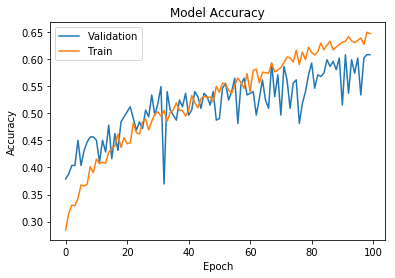

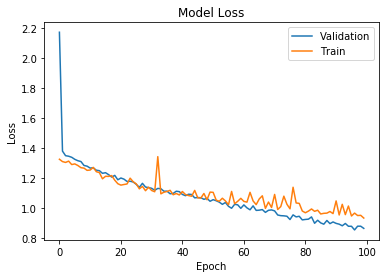

In [74]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation','Train'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper right')
plt.show()

In [76]:
# determine the ROC AUC score 

print(X_test.shape, y_test.shape)
# determine the classification accuracy
score, accuracy = parallel_model.evaluate(X_test, y_test)
y_pred = parallel_model.predict(X_test)
print("\nAccuracy = {:.2f}".format(accuracy))

(322, 60, 1722, 1) (322, 4)
322/322 [==============================] - 0s 896us/step

Accuracy = 0.58


In [77]:
#y_pred = model.predict(test_x)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(y_pred1.shape,y_test1.shape)

(322,) (322,)


In [84]:
unique_categories = uniqueLabels
unique_categories

['Bach', 'Brahms', 'Mozart', 'Schubert']

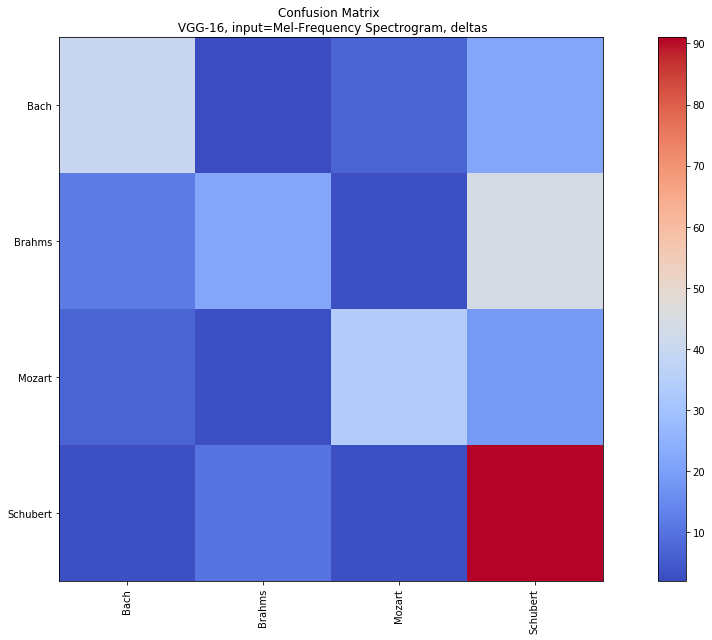

<Figure size 1440x1440 with 0 Axes>

In [86]:
#Error Analysis: Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1, y_pred1)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,10))
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix \n VGG-16, input=Mel-Frequency Spectrogram, deltas')
plt.colorbar()
tick_marks = np.arange(len(unique_categories))
plt.xticks(tick_marks, unique_categories, rotation=90)
plt.yticks(tick_marks, unique_categories)
plt.figure(figsize=(20,20))
# plt.savefig('_cm.png')
plt.show()

<Figure size 1440x720 with 0 Axes>

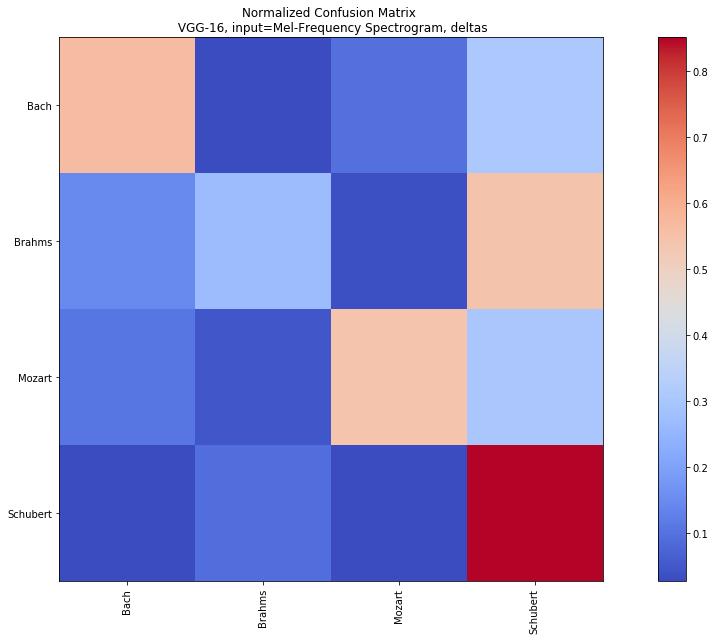

In [87]:
#Error Analysis: Confusion Matrix
plt.figure(figsize=(20,10))
cm = confusion_matrix(y_test1, y_pred1)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,10))
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
plt.title('Normalized Confusion Matrix \n VGG-16, input=Mel-Frequency Spectrogram, deltas')
plt.colorbar()
tick_marks = np.arange(len(unique_categories))
plt.xticks(tick_marks, unique_categories, rotation=90)
plt.yticks(tick_marks, unique_categories)
# plt.savefig('VGG16_input_melspec&deltas_Ncm.png')
plt.show()